In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
from argparse import Namespace
import copy
import gzip
import itertools
import math
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from Levenshtein import distance as _edit_distance
import numpy as np
import pandas as pd
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tabulate
import tqdm
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *

2023-05-30 16:58:40 - ast_utils - DEBUG    - Using cache folder: /tmp/game_generation_cache
2023-05-30 16:58:40 - src.ast_utils - DEBUG    - Using cache folder: /tmp/game_generation_cache
2023-05-30 16:58:41 - git.cmd - DEBUG    - Popen(['git', 'version'], cwd=/Users/guydavidson/projects/game-generation-modeling/notebooks, universal_newlines=False, shell=None, istream=None)
2023-05-30 16:58:41 - git.cmd - DEBUG    - Popen(['git', 'version'], cwd=/Users/guydavidson/projects/game-generation-modeling/notebooks, universal_newlines=False, shell=None, istream=None)


In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


In [4]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,num_preferences_defined_1,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,0,...,0.979840,0.981232,0.972647,0.982941,0.983447,0.985028,0.921708,0.915602,0.974574,0.987208
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,0,...,0.982149,0.982984,0.969335,0.980352,0.979375,0.985628,0.924200,0.931860,0.945369,0.962395
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,1,...,0.976339,0.980711,0.000000,0.000000,0.000000,0.000000,0.847204,0.858832,0.923039,0.942806
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,1,...,0.987455,0.987147,0.000000,0.000000,0.000000,0.000000,0.921708,0.915602,0.974574,0.987208
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0,...,0.982912,0.981247,0.000000,0.000000,0.000000,0.000000,0.979536,0.978090,0.970715,0.987258


In [5]:
postprocessor = ast_parser.ASTSamplePostprocessor()
postprocessed_real_game_texts = [ast_printer.ast_to_string(postprocessor(ast), '\n') for ast in game_asts]  # type: ignore

real_game_edit_distances = np.zeros((len(game_asts), len(game_asts)), dtype=int)
for i, j in itertools.combinations(range(len(game_asts)), 2):
    real_game_edit_distances[i, j] = real_game_edit_distances[j, i] = edit_distance(postprocessed_real_game_texts[i], postprocessed_real_game_texts[j])


def edit_distance(first_game_text: str, second_game_text: str):
    first_game_text = first_game_text[first_game_text.find(')', first_game_text.find('(:domain')) + 1:]
    second_game_text = second_game_text[second_game_text.find(')', second_game_text.find('(:domain')) + 1:]
    return _edit_distance(first_game_text, second_game_text)


def find_nearest_real_game_indices(game, k: int = 3) -> typing.Tuple[np.ndarray, np.ndarray]:
    game_str = ast_printer.ast_to_string(game, '\n')
    distances = np.array([edit_distance(game_str, real_game) for real_game in postprocessed_real_game_texts])
    nearest_real_game_indices = np.argsort(distances)[:k]
    return nearest_real_game_indices, distances[nearest_real_game_indices]


def print_nearest_real_games(game, k: int = 3):
    indices, distances = find_nearest_real_game_indices(game, k)
    for i, (idx, d) in enumerate(zip(indices, distances)):
        real_game_distances = real_game_edit_distances[idx]
        nearest_distance_indices = np.argsort(real_game_distances)[1:k + 1]  # index 0 is the game itself
        display(Markdown(f'### Nearest real game #{i + 1}:'))
        display(Markdown(f'Edit distance to sample {d}, real game nearest neighbor distances {np.array2string(real_game_distances[nearest_distance_indices], separator=", ")}):\n'))
        display(Markdown(f'```pddl\n{real_game_texts[idx]}\n```'))


In [6]:
HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS = dict(hspace=0.3)


def plot_value_histograms(results_by_feature_name_and_value: typing.Dict[str, typing.Dict[int, typing.List[float]]],
    bins: int = 20, histogram_log_y: bool = False, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    k = len(results_by_feature_name_and_value.keys())

    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    for i, feature_name in enumerate(results_by_feature_name_and_value.keys()):
        if layout[0] == 1:
            ax = axes[i]
        else:
            ax = axes[i // layout[1]][i % layout[1]]

        values_with = results_by_feature_name_and_value[feature_name][1]
        values_without = results_by_feature_name_and_value[feature_name][0]

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([values_with, values_without], label=[f'1 (n={len(values_with)})', f'0 (n={len(values_without)})'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Fitness value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title = f'#{i + 1}: {feature_name}'
        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()


def analyze_archive_fullness(model: MAPElitesSampler, mutually_exclusive_features: typing.Optional[typing.List[str]] = None,
                             plot_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):
    if plot_kwargs is None:
        plot_kwargs = {}
    
    results_by_feature_name = {feature_name: defaultdict(list) for feature_name in model.map_elites_feature_names}
    results_by_feature_count = defaultdict(list)

    for key, fitness_value in model.fitness_values.items():
        for feature_name, feature_value in model._key_to_feature_dict(key).items():
            results_by_feature_name[feature_name][feature_value].append(fitness_value)

        if isinstance(key, int):
            key_bits = count_set_bits(key)
        else:
            key_bits = sum(k != 0 for k in key)

        results_by_feature_count[key_bits].append(fitness_value)

    display(Markdown(f'## Archive fullness analysis'))
    display(Markdown(f'Ttoal of {len(model.fitness_values)} samples in archive, {len(model.map_elites_feature_names)} features'))
    display(Markdown(f'### Results by feature'))
    lines = []
    for feature_name, results in results_by_feature_name.items():
        lines.append(f'- {feature_name}:')
        for feature_value in sorted(results.keys()):
            value_results = results[feature_value]
            lines.append(f'    - ={feature_value}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)})')

    display(Markdown('\n'.join(lines)))

    display(Markdown(f'### Results by set feature count'))
    lines = []
    for feature_count in sorted(results_by_feature_count.keys()):
        value_results = results_by_feature_count[feature_count]
        lines.append(f'- set-count={feature_count}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)} / {math.comb(len(model.map_elites_feature_names), feature_count)})')

    display(Markdown('\n'.join(lines)))

    plot_value_histograms(results_by_feature_name, **plot_kwargs)


In [7]:
SUBPLOTS_ADJUST_PARAMS = dict(top=0.925)
 

def plot_sampler_fitness_trajectory(evo: PopulationBasedSampler, title: typing.Optional[str] = None, axsize: typing.Tuple[int, int] = (8, 6),
                                    plot_metrics: typing.Optional[bool] = None, subplots_adjust_params: typing.Dict[str, float] = SUBPLOTS_ADJUST_PARAMS,
                                    min_real_game_fitness: float = 121.7345, max_real_game_fitness: float = 130.0416):  

    
    
    if plot_metrics is None:
        plot_metrics = hasattr(evo, 'archive_metrics_history') and len(evo.archive_metrics_history) > 0
            
    layout = (1, 2) if plot_metrics else (1, 1)
    figsize = (axsize[0] * layout[1], axsize[1])

    fig, axes = plt.subplots(*layout, figsize=figsize)

    mean, max_fit, std = [], [], []
    for step_dict in evo.fitness_metrics_history:
        mean.append(step_dict['mean'])
        max_fit.append(step_dict['max'])
        std.append(step_dict['std'])

    mean = np.array(mean)
    max_fit = np.array(max_fit)
    std = np.array(std)

    fitness_ax = typing.cast(matplotlib.axes.Axes, axes[0] if plot_metrics else axes)

    fitness_ax.plot(mean, label='mean fitness')
    fitness_ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2, label='std')  # type; ignore
    fitness_ax.plot(max_fit, label='max fitness')

    fitness_ax.hlines(min_real_game_fitness, 0, len(mean), label='min real game fitness', color='black', ls='--')
    fitness_ax.hlines(max_real_game_fitness, 0, len(mean), label='max real game fitness', color='black', ls='--')

    fitness_ax.set_xlabel('Generation')
    fitness_ax.set_ylabel('Fitness')

    fitness_ax.legend(loc='best')
    
    if plot_metrics:
        metrics = {key: [] for key in evo.archive_metrics_history[0].keys()}
        for step_dict in evo.archive_metrics_history:
            for key, value in step_dict.items():
                metrics[key].append(value)

        metrics_ax = typing.cast(matplotlib.axes.Axes, axes[1])
        for key, values in metrics.items():
            metrics_ax.plot(values, label=key)

        metrics_ax.set_xlabel('Generation')
        metrics_ax.set_ylabel('Metric Value')

        metrics_ax.legend(loc='best')

        plt.subplots_adjust(**subplots_adjust_params)
        
    if title is not None:
        if plot_metrics:
            plt.suptitle(title)
        else:
            plt.title(title)

    plt.show()


def count_games_above_fitness_threshold(evo: PopulationBasedSampler, threshold: float) -> int:
    if isinstance(evo.fitness_values, dict):
        fitness_values = evo.fitness_values.values()
    else:
        fitness_values = evo.fitness_values

    return sum(1 for fitness in fitness_values if fitness >= threshold)

In [ ]:
# fitness_rank_node_count_objects = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_fitness_rank_node_count_objects_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_node_count_objects, 'MAP-Elites, Node Count, Unique Objects, & Setup Features, Fitness Rank')

# fitness_rank_node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_fitness_rank_node_count_predicates_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_node_count_predicates, 'MAP-Elites, Node Count, Unique Predicates, & Setup Features, Fitness Rank')

# ucb_node_count_objects = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_ucb_node_count_objects_setup_final'))
# plot_sampler_fitness_trajectory(ucb_node_count_objects, 'MAP-Elites, Node Count, Unique Objects, & Setup Features, UCB')

# ucb_node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_ucb_node_count_predicates_setup_final'))
# plot_sampler_fitness_trajectory(ucb_node_count_predicates, 'MAP-Elites, Node Count, Unique Predicates, & Setup Features, UCB')


In [ ]:
# fitness_rank_object_categories = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_categories_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_object_categories, 'MAP-Elites, Object Categories & Setup Exists Features, Fitness Rank')

# fitness_rank_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_predicates_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_predicates, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank')

# fitness_rank_object_categories_crossover = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_categories_setup_crossover_final'))
# plot_sampler_fitness_trajectory(fitness_rank_object_categories_crossover, 'MAP-Elites, Object Categories & Setup Exists Features, Fitness Rank, With Crossover')

# fitness_rank_predicates_crossover = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_predicates_setup_crossover_final'))
# plot_sampler_fitness_trajectory(fitness_rank_predicates_crossover, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, With Crossover')

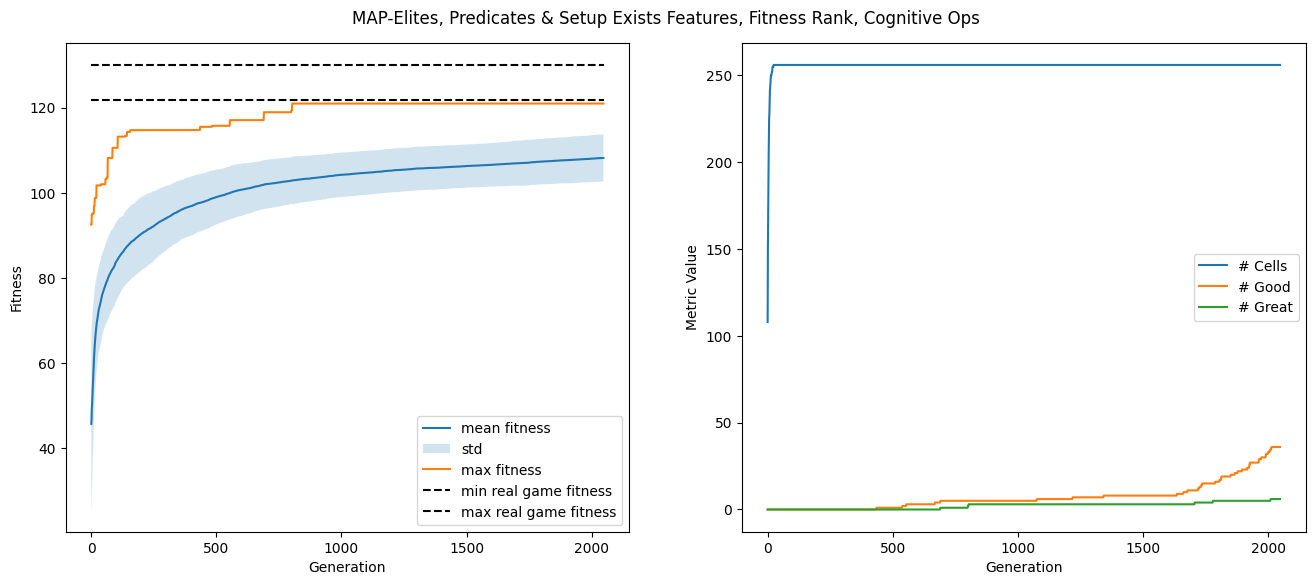

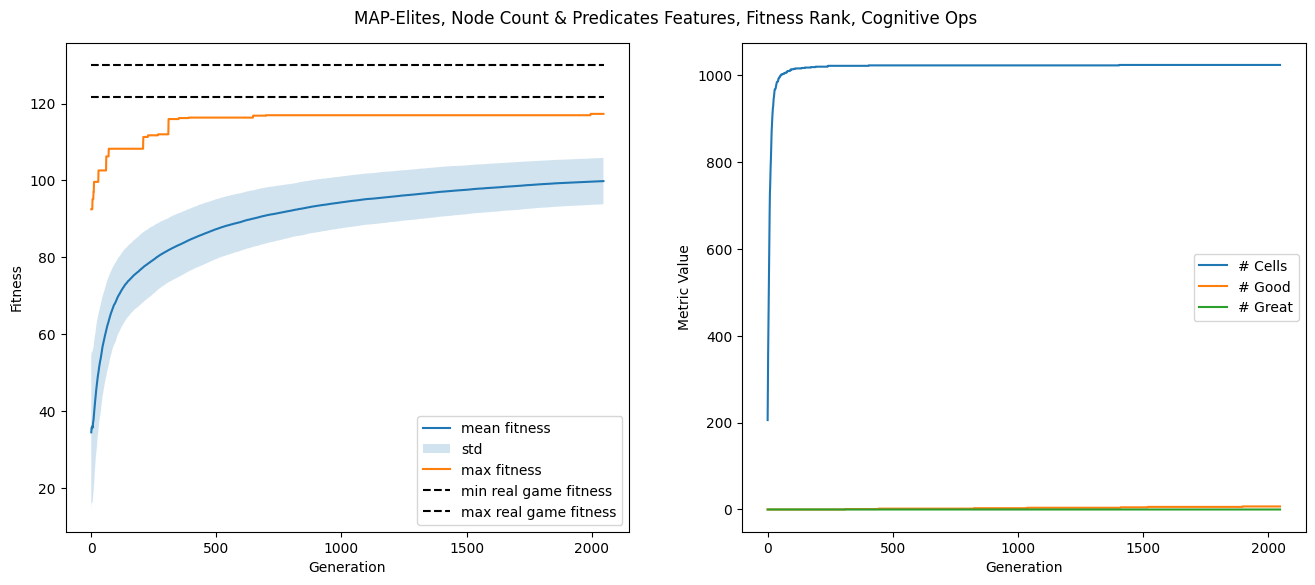

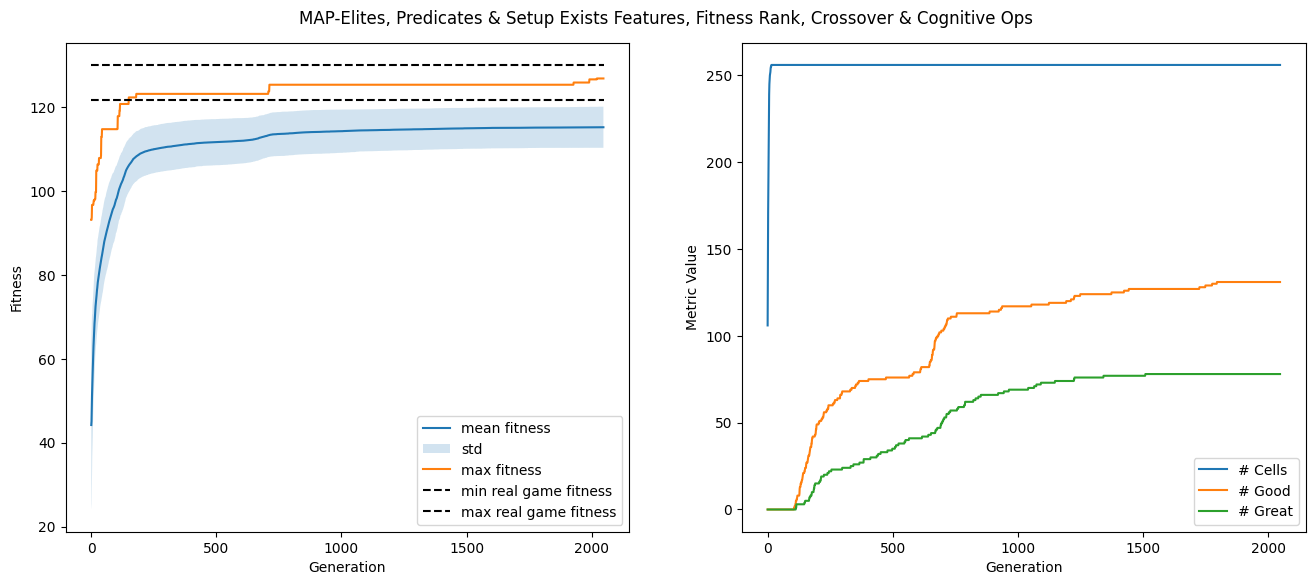

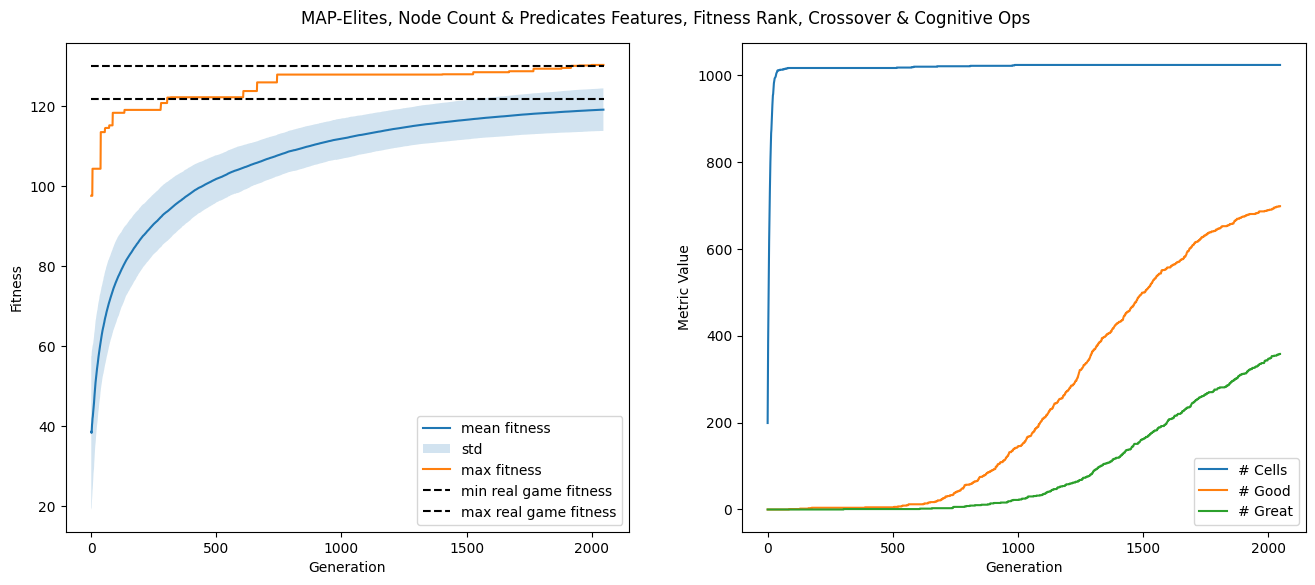

In [8]:
fitness_rank_predicates_cognitive = typing.cast(MAPElitesSampler, utils.load_data('2023_05_23', 'samples', 'map_elites_fitness_rank_specific_predicates_setup_cognitive_ops_experiment_final'))
plot_sampler_fitness_trajectory(fitness_rank_predicates_cognitive, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, Cognitive Ops')

fitness_rank_node_count_predicates_cognitive = typing.cast(MAPElitesSampler, utils.load_data('2023_05_23', 'samples', 'map_elites_fitness_rank_node_count_specific_predicates_cognitive_ops_experiment_final'))
plot_sampler_fitness_trajectory(fitness_rank_node_count_predicates_cognitive, 'MAP-Elites, Node Count & Predicates Features, Fitness Rank, Cognitive Ops')

fitness_rank_predicates_crossover_cognitive = typing.cast(MAPElitesSampler, utils.load_data('2023_05_23', 'samples', 'map_elites_fitness_rank_specific_predicates_setup_crossover_cognitive_ops_experiment_final'))
plot_sampler_fitness_trajectory(fitness_rank_predicates_crossover_cognitive, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, Crossover & Cognitive Ops')

fitness_rank_node_count_predicates_crossover_cognitive = typing.cast(MAPElitesSampler, utils.load_data('2023_05_25', 'samples', 'map_elites_fitness_rank_node_count_specific_predicates_crossover_cognitive_ops_experiment_final'))
plot_sampler_fitness_trajectory(fitness_rank_node_count_predicates_crossover_cognitive, 'MAP-Elites, Node Count & Predicates Features, Fitness Rank, Crossover & Cognitive Ops')

# fitness_rank_object_categories_cognitive = typing.cast(MAPElitesSampler, utils.load_data('2023_05_16', 'samples', 'map_elites_fitness_rank_node_count_specific_predicates_cognitive_ops_experiment_final'))
# plot_sampler_fitness_trajectory(fitness_rank_object_categories_cognitive, 'MAP-Elites, Node count & Predicates Features, Fitness Rank, Cognitive Ops')

# fitness_rank_object_categories_crossover_cognitive = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_node_count_specific_predicates_crossover_cognitive_ops_experiment_final'))
# plot_sampler_fitness_trajectory(fitness_rank_object_categories_crossover_cognitive, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, Crossover & Cognitive Ops')

In [13]:
model = fitness_rank_node_count_predicates_crossover_cognitive
index = 1

key = model.top_sample_key(index)
sample = model.population[key]
sample_features = fitness_rank_node_count_predicates_crossover_cognitive.fitness_featurizer.parse(sample, return_row=True, preprocess_row=False)

{key: value for key, value in sample_features.items() if 'forall' in key}


{'pref_forall_count_once_per_external_objects_used_correct': 0,
 'pref_forall_count_once_per_external_objects_used_incorrect': 0,
 'pref_forall_external_forall_used_correct': 0,
 'pref_forall_external_forall_used_incorrect': 1.0,
 'pref_forall_used_correct': 0,
 'pref_forall_used_incorrect': 2.0,
 'pref_forall_pref_forall_correct_arity_correct': 0,
 'pref_forall_pref_forall_correct_arity_incorrect': 0,
 'pref_forall_pref_forall_correct_types_correct': 0,
 'pref_forall_pref_forall_correct_types_incorrect': 0}

* TODO: fix the features above so they count individual occurrences, not just each individual preference once
* TODO: penalize identical preferences?
* TODO: penalize identical expressions in the scoring?

Relevant games: #1,27?,40 in the `node_count_predicates` model, #3,7?,9?,19,21 in the `predicates_setup` model

In [15]:
# model = evo_sampler_map_elites_fitness_rank_no_at_end
model = fitness_rank_node_count_predicates_crossover_cognitive
index = 1
n_features_on = None
feature_keywords_to_print = None  # ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3
key_features = None  # dict(section_doesnt_exist_setup=0)

key = model.visualize_top_sample(index, feature_keywords_to_print=feature_keywords_to_print, n_features_on=n_features_on, 
    postprocess_sample=True, features=key_features)
print_nearest_real_games(model.population[key], n_similar_real_games_to_print)

Sample features for key (7, 1, 1, 0, 0, 1, 1, 1):
node_count: 7
predicate_used_adjacent: 1
predicate_used_agent_holds: 1
predicate_used_between: 0
predicate_used_in: 0
predicate_used_in_motion: 1
predicate_used_on: 1
predicate_used_touch: 1


### Energy of visualized game: -130.258

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                | Features decreasing energy (= more real)                                       |
|-------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| compositionality_structure_2: **0.971** = (1.000) * 0.971               | ast_ngram_full_n_7_score: **-40.689** = (0.878) * -46.340                      |
| in_motion_arg_types_blocks_constraints: **0.759** = (1.000) * 0.759     | ast_ngram_constraints_n_7_score: **-24.888** = (0.872) * -28.558               |
| node_count_setup_2: **0.687** = (1.000) * 0.687                         | ast_ngram_scoring_n_5_score: **-12.481** = (0.940) * -13.278                   |
| pref_forall_used_incorrect: **0.619** = (0.077) * 8.044                 | ast_ngram_setup_n_5_score: **-11.860** = (0.908) * -13.065                     |
| in_motion_arg_types_any_object_constraints: **0.551** = (1.000) * 0.551 | all_preferences_used: **-6.164** = (1.000) * -6.164                            |
| node_count_scoring_4: **0.506** = (1.000) * 0.506                       | all_variables_used: **-5.742** = (1.000) * -5.742                              |
| length_of_then_modals_1: **0.369** = (1.000) * 0.369                    | ast_ngram_terminal_n_5_score: **-5.300** = (0.970) * -5.466                    |
| predicate_under_modal_once_in_motion: **0.320** = (1.000) * 0.320       | setup_quantified_objects_used: **-2.405** = (1.000) * -2.405                   |
| max_depth_setup_2: **0.183** = (1.000) * 0.183                          | num_preferences_defined_3: **-2.345** = (1.000) * -2.345                       |
| predicate_under_modal_once_on: **0.183** = (1.000) * 0.183              | max_width_terminal_0: **-2.099** = (1.000) * -2.099                            |
| starts_and_ends_once: **0.169** = (0.333) * 0.508                       | all_variables_defined: **-1.900** = (1.000) * -1.900                           |
| agent_holds_arg_types_blocks_constraints: **0.083** = (1.000) * 0.083   | on_arg_types_furniture_any_object_constraints: **-1.787** = (1.000) * -1.787   |
| no_adjacent_same_modal: **0.081** = (-1.000) * -0.081                   | mean_depth_constraints_1: **-1.703** = (1.000) * -1.703                        |
| predicate_under_modal_once_touch: **0.042** = (1.000) * 0.042           | max_depth_constraints_1: **-1.658** = (1.000) * -1.658                         |
| pref_forall_external_forall_used_incorrect: **0.032** = (0.125) * 0.256 | predicate_under_modal_hold_agent_holds: **-1.468** = (1.000) * -1.468          |
|                                                                         | predicate_under_modal_once_agent_holds: **-1.241** = (1.000) * -1.241          |
|                                                                         | predicate_under_modal_once_adjacent: **-1.182** = (1.000) * -1.182             |
|                                                                         | compositionality_structure_6: **-1.150** = (1.000) * -1.150                    |
|                                                                         | touch_arg_types_balls_room_features_constraints: **-1.092** = (1.000) * -1.092 |
|                                                                         | mean_depth_scoring_4: **-0.952** = (1.000) * -0.952                            |

### Game:

```pddl
(define (game evo-2000-190-0) (:domain many-objects-room-v1)
(:setup
  (and
    (exists (?v0 - hexagonal_bin)
      (and
        (exists (?v1 - hexagonal_bin)
          (game-conserved
            (and
              (on bed ?v0)
              (object_orientation ?v1 sideways)
            )
          )
        )
      )
    )
  )
(:constraints
  (and
    (preference preference0
      (exists (?v0 - game_object)
        (then
          (once (and (not (in_motion ?v0) ) (on bed ?v0) ) )
        )
      )
    )
    (preference preference1
      (exists (?v2 - dodgeball ?v3 - hexagonal_bin)
        (then
          (once (and (adjacent ?v3 agent) (touch floor ?v2) ) )
        )
      )
    )
    (preference preference2
      (exists (?v2 - bridge_block)
        (then
          (once (agent_holds ?v2) )
          (hold (and (in_motion ?v2) (not (agent_holds ?v2) ) ) )
          (hold (agent_holds ?v2) )
          (once (not (agent_holds ?v2) ) )
        )
      )
    )
  )
)
(:terminal
  (>= (external-forall-maximize (count preference1) ) 20 )
)
(:scoring
  (* 2 (* 2 (* 2 (count-once-per-objects preference1) (* 16 (count-once-per-objects preference0) (* 2 (count-once-per-objects preference0) (* 16 (count-once-per-objects preference2) (* 2 (count preference1) (* 15 (* 2 (count-once-per-objects preference2) (* 50 (count-once-per-objects preference0:yellow) )
                  )
                  (* 5 (count preference2) )
                )
              )
              (* 5 (count preference2) )
            )
          )
          (* 5 (count preference0) )
        )
      )
      (* 0 (count-once-per-objects preference2) (* 50 (count-once-per-objects preference2) )
        (* 5 (count preference0) )
      )
      (* 5 (count preference0) )
    )
  )
)
)
```

### Nearest real game #1:

Edit distance to sample 1103, real game nearest neighbor distances [492, 502, 505]):


```pddl
(define (game 5b94d723839c0a00010f88d9-103) (:domain few-objects-room-v1)
(:setup
  (and
    (exists (?h - hexagonal_bin)
      (game-conserved
        (and
          (on bed ?h)
          (object_orientation ?h sideways)
        )
      )
    )
  )
)
(:constraints
  (and
    (preference dodgeballHitsBin
      (exists (?d - dodgeball ?h - hexagonal_bin)
        (then
          (once (agent_holds ?d) )
          (hold-while (and (in_motion ?d) (not (agent_holds ?d) ) (not (in ?h ?d) ) ) (touch ?h ?d) )
          (once (and (not (in_motion ?d) ) (not (in ?h ?d) ) ) )
        )
      )
    )
    (preference dodgeballHitsBinBottom
      (exists (?d - dodgeball ?h - hexagonal_bin)
        (then
          (once (agent_holds ?d) )
          (hold-while (and (in_motion ?d) (not (agent_holds ?d) ) ) (in ?h ?d) )
          (once (and (not (in_motion ?d) ) ) )
        )
      )
    )
    (preference throwAttempt
      (exists (?d - dodgeball)
        (then
          (once (agent_holds ?d) )
          (hold (and (in_motion ?d) (not (agent_holds ?d) ) ) )
          (once (and (not (in_motion ?d) ) ) )
        )
      )
    )
  )
)
(:terminal
  (>= (count throwAttempt) 10 )
)
(:scoring
  (+ (count dodgeballHitsBin) (* 2 (count dodgeballHitsBinBottom) )
  )
)
)
```

### Nearest real game #2:

Edit distance to sample 1132, real game nearest neighbor distances [501, 510, 539]):


```pddl
(define (game 613e18e92e4ed15176362aa2-117) (:domain medium-objects-room-v1)
(:setup
  (and
    (exists (?h - hexagonal_bin ?r - triangular_ramp)
      (game-conserved
        (< (distance ?h ?r) 2)
      )
    )
  )
)
(:constraints
  (and
    (preference redDodgeballThrownToBinWithoutTouchingFloor
      (exists (?h - hexagonal_bin ?r - red_dodgeball)
        (then
          (once (agent_holds ?r) )
          (hold (and (not (agent_holds ?r) ) (in_motion ?r) (not (touch floor ?r) ) ) )
          (once (and (not (in_motion ?r) ) (in ?h ?r) ) )
        )
      )
    )
    (preference redDodgeballThrownToBin
      (exists (?h - hexagonal_bin ?r - red_dodgeball)
        (then
          (once (agent_holds ?r) )
          (hold (and (not (agent_holds ?r) ) (in_motion ?r) ) )
          (once (and (not (in_motion ?r) ) (in ?h ?r) ) )
        )
      )
    )
    (preference throwAttempt
      (exists (?r - red_dodgeball)
        (then
          (once (agent_holds ?r) )
          (hold (and (not (agent_holds ?r) ) (in_motion ?r) ) )
          (once (not (in_motion ?r) ) )
        )
      )
    )
  )
)
(:terminal
  (or
    (>= (count throwAttempt) 10 )
    (>= (count-once redDodgeballThrownToBinWithoutTouchingFloor) 1 )
    (>= (count-once redDodgeballThrownToBin) 1 )
  )
)
(:scoring
  (+ (* 5 (count-once redDodgeballThrownToBin) )
    (* 3 (= (count throwAttempt) 1 )
      (count-once redDodgeballThrownToBinWithoutTouchingFloor)
    )
    (* 2 (< (count throwAttempt) 5 )
      (count-once redDodgeballThrownToBinWithoutTouchingFloor)
    )
  )
)
)
```

### Nearest real game #3:

Edit distance to sample 1145, real game nearest neighbor distances [699, 798, 851]):


```pddl
(define (game 606e4eb2a56685e5593304cd-27) (:domain few-objects-room-v1)
(:setup
  (and
    (forall (?d - (either dodgeball cube_block))
      (game-optional
        (not
          (exists (?s - shelf)
            (on ?s ?d)
          )
        )
      )
    )
    (game-optional
      (toggled_on main_light_switch)
    )
    (game-optional
      (toggled_on desktop)
    )
  )
)
(:constraints
  (and
    (preference dodgeballsInPlace
      (exists (?d - dodgeball ?h - hexagonal_bin)
        (at-end
          (in ?h ?d)
        )
      )
    )
    (preference blocksInPlace
      (exists (?c - cube_block ?s - shelf)
        (at-end
          (and
            (adjacent ?s west_wall)
            (on ?s ?c)
          )
        )
      )
    )
    (preference laptopAndBookInPlace
      (exists (?o - (either laptop book) ?s - shelf)
        (at-end
          (and
            (adjacent ?s south_wall)
            (on ?s ?o)
          )
        )
      )
    )
    (preference smallItemsInPlace
      (exists (?o - (either cellphone key_chain) ?d - drawer)
        (at-end
          (and
            (in ?d ?o)
          )
        )
      )
    )
    (preference itemsTurnedOff
      (exists (?o - (either main_light_switch desktop laptop))
        (at-end
          (and
            (not
              (toggled_on ?o)
            )
          )
        )
      )
    )
  )
)
(:scoring
  (+ (* 5 (+ (count-once-per-objects dodgeballsInPlace) (count-once-per-objects blocksInPlace) (count-once-per-objects laptopAndBookInPlace) (count-once-per-objects smallItemsInPlace) )
    )
    (* 3 (count-once-per-objects itemsTurnedOff) )
  )
)
)
```

In [ ]:
model = fitness_rank_predicates

def real_games_to_keys(map_elites_sampler: MAPElitesSampler, real_asts: typing.List[tatsu.ast.AST]) -> typing.List[str]:
    return set([map_elites_sampler._features_to_key(ast, map_elites_sampler._proposal_to_features(ast)) for ast in real_asts])
    

real_game_keys = real_games_to_keys(model, game_asts)
high_quality_sample_keys = set([k for k, v in model.fitness_values.items() if v > 70])
high_quality_no_real_game_keys = high_quality_sample_keys - real_game_keys
print(len(real_game_keys), len(high_quality_sample_keys), len(real_game_keys.intersection(high_quality_sample_keys)), len(high_quality_no_real_game_keys))


high_quality_no_real_game_keys = [t[0] for t in sorted([(k, model.fitness_values[k]) for k in high_quality_sample_keys if k not in real_game_keys], key=lambda x: x[1], reverse=True)]

In [ ]:
index = 6
key = high_quality_no_real_game_keys[index]
n_features_on = None
feature_keywords_to_print = ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3 
key_features = dict(section_doesnt_exist_setup=0)

key = model._visualize_sample_by_key(key, feature_keywords_to_print=feature_keywords_to_print, postprocess_sample=True)
print_nearest_real_games(model.population[key], n_similar_real_games_to_print)

In [ ]:
def count_set_bits(n): 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in current_uniform.fitness_values.items():
    key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [ ]:
threshold = 70

def count_set_bits(n):
 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in evo_sampler_map_elites_ucb.fitness_values.items():
    if fitness > threshold:
        key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [ ]:
from src.evolutionary_sampler_behavioral_features import build_behavioral_features_featurizer, BASIC_BINNED, BASIC_WITH_NODE_DEPTH


featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(current_thompson.population[current_thompson.top_sample_key(i)], 'interactive-beta.pddl', return_row=False) for i in range(1, 51)]
d_generated = featurizer.to_df()
d_generated.describe()

In [ ]:
featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
d_real = featurizer.to_df()

In [ ]:
%matplotlib widget


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
generated_values = d_generated[featurizer.headers[4:-1]].values.T.astype(float)
real_values = d_real[featurizer.headers[4:-1]].values.T.astype(float)
generated_values += np.random.normal(0, 0.1, size=generated_values.shape)
real_values += np.random.normal(0, 0.1, size=real_values.shape)
ax.scatter(*real_values, s=10)
ax.scatter(*generated_values, s=10)
ax.set_xlabel('Node count')
ax.set_ylabel('# Objects')
ax.set_zlabel('# Predicates')

plt.show()

In [17]:
fitness_df.groupby('real')[[c for c in fitness_df.columns if 'length_of_then' in c]].mean()

,length_of_then_modals_1,length_of_then_modals_2,length_of_then_modals_3,length_of_then_modals_4,length_of_then_modals_5,length_of_then_modals_6,length_of_then_modals_7
real,,,,,,,
0,0.004534,0.015834,0.821997,0.073930,0.019651,0.000349,0.0
1,0.000000,0.010204,0.816327,0.071429,0.020408,0.000000,0.0
